In [1]:
#Standard Python modules:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import brewer2mpl

#ECP modules:
import PlotTools.plot_tools as PTs

# Dsiplay options:
from matplotlib.pyplot import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (15.,10)



In [78]:
JULES_dir='/prj/GREENHOUSE/CHESS_runs/jules_output/Jvn4.5/'
JULES_filetag='chess_v1.0_ECP.monthly_vegcarb.YYYY.nc'
JULES_vars=['fch4_wetl','npp_gb','resp_s_gb','cs']

PLEVY_dir='/prj/GREENHOUSE/PLEVY_BU_estimates/'
PLEVY_filetag='uk_flux_SOURCE_SPECIES_OSGB.YYYY.annual.nc'
#PLEVY_SOURCES=['agric','natural']
PLEVY_SOURCES=['natural']
PLEVY_SPECIES=['co2','ch4']

JULES_albmar_dir='/prj/GREENHOUSE/CHESS_runs/jules_output/albmar_Jvn4.5/'
JULES_albmar_filetag='chess_v1.1.bgc_monthly.nc'
JULES_albmar_vars=['npp_gb','resp_s_gb']

JULES_CHESS_gridfile='/users/eow/edwcom/CHESS/chess_jules_land_index.nc'

CHESS_landcover_file='/prj/chess/data/1km/v1.0/ancil/chess_landcover_2000.nc'


In [3]:
grinf=nc.Dataset(JULES_CHESS_gridfile,'r')
grindex=grinf.variables['index_2D'][:]
lats_2D=grinf.variables['lats_2D'][:]
lons_2D=grinf.variables['lons_2D'][:]
grinf.close()

In [4]:
LCinf=nc.Dataset(CHESS_landcover_file,'r')
LCfrac=LCinf.variables['frac'][:]
x=LCinf.variables['x'][:]
y=LCinf.variables['y'][:]
LCinf.close()

In [5]:
year=2014
days_in_month=np.array([31,28,31,30,31,30,31,31,30,31,30,31])
print(days_in_month.shape)

(12,)


In [62]:
# Read in JULES data and convert units:
Jinf=nc.Dataset(JULES_dir+JULES_filetag.replace('YYYY',str(year)),'r')
JULES_DATA={}
for var in JULES_vars:
    JULES_DATA[var]={'data': np.ma.masked_array( Jinf.variables[var][:].squeeze()[:,grindex], 
                                                 mask=[grindex.mask for i in range(12) ] )} #, \
                                                 #* 86400. * 1e6, \
                     #                          sec to day * m2 to km2 
                     #'units':'kg km^-2 day^-1'}
    
Jinf.close()   

#JULES_DATA['cs']['data']=np.sqrt(JULES_DATA['cs']['data'])
JULES_DATA['cs']['units']='kg m^-2'

JULES_DATA['fch4_wetl']['data']*=1e-9*86400. #
JULES_DATA['fch4_wetl']['units']='g m^-2 day^-1'

JULES_DATA['resp_s_gb']['data']*=86400.* 0.162 # scales to P.Levy natural co2 flux
JULES_DATA['resp_s_gb']['units']='kg m^-2 day^-1'

JULES_DATA['npp_gb']['data']*=86400.
JULES_DATA['npp_gb']['units']='kg m^-2 day^-1'

JULES_DATA['co2_flux']={'data':JULES_DATA['npp_gb']['data']-JULES_DATA['resp_s_gb']['data'],\
                        'units':'kg km^-2 day^-1'}

('npp_gb', 'resp_s_gb', 'co2_flux')
npp_gb (1057, 656) 0.812859926583


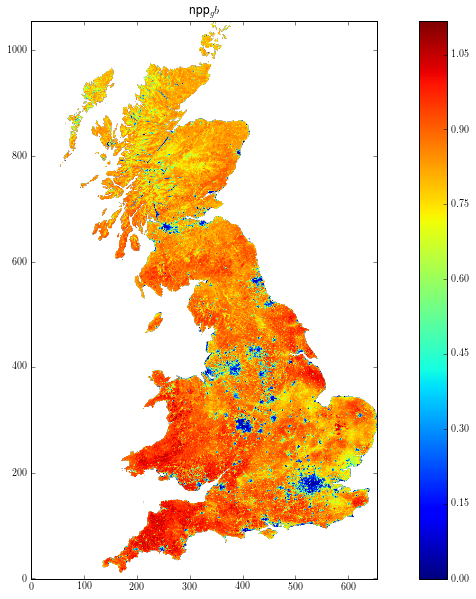

resp_s_gb (1057, 656) 0.359945136856


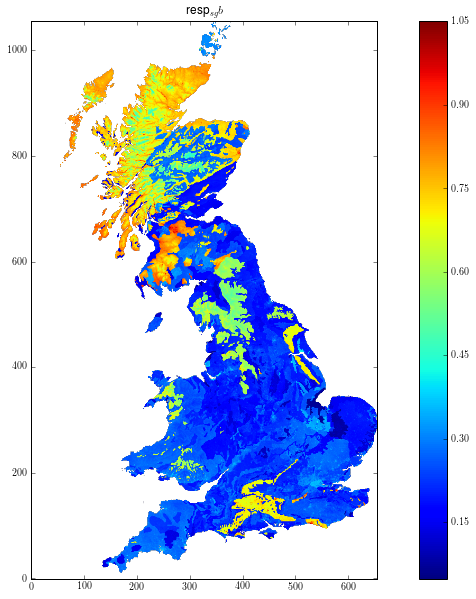

co2_flux (1057, 656) 0.452914789877


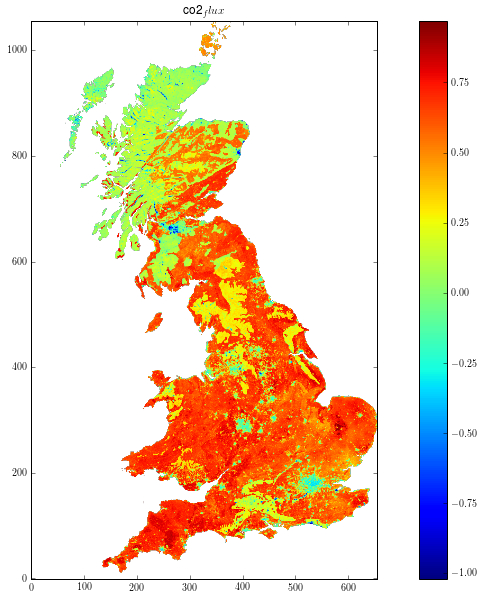

In [63]:
vars='npp_gb','resp_s_gb','co2_flux'
#vars=list(JULES_vars)+['co2_flux']
print(vars)
for var in vars:
    if str(var) =='cs':
        plotdata=JULES_DATA[var]['data'][0,:]
    else:
        plotdata=np.mean(JULES_DATA[var]['data'],axis=0)*365.
    print(var,plotdata.shape, np.mean(plotdata))
    plt.imshow(plotdata,origin='bottom')
    plt.title(var)
    plt.colorbar()
    plt.show()


In [54]:
# Read in JULES data and convert units:
Jfname=JULES_albmar_dir+JULES_albmar_filetag.replace('YYYY',str(year))
print(Jfname)
Jinf=nc.Dataset(Jfname,'r')
JULES_albmar_DATA={}
for var in JULES_albmar_vars:
    JULES_albmar_DATA[var]={'data': np.ma.masked_array( Jinf.variables[var][12:24,:].squeeze()[:,grindex], 
                                                 mask=[grindex.mask for i in range(12) ] )} #, \
                 
Jinf.close()   

JULES_albmar_DATA['resp_s_gb']['data']*=86400.
JULES_albmar_DATA['resp_s_gb']['units']='kg m^-2 day^-1'

JULES_albmar_DATA['npp_gb']['data']*=86400.
JULES_albmar_DATA['npp_gb']['units']='kg m^-2 day^-1'

JULES_albmar_DATA['co2_flux']={'data':JULES_albmar_DATA['npp_gb']['data']     \
                                      -JULES_albmar_DATA['resp_s_gb']['data'],\
                              'units':'kg km^-2 day^-1'}

/prj/GREENHOUSE/CHESS_runs/jules_output/albmar_Jvn4.5/chess_v1.1.bgc_monthly.nc


In [9]:

#for var in JULES_albmar_DATA:
#    #if var =='cs':
#    #    plotdata=np.mean(JULES_albmar_DATA[var]['data'],axis=0)
#    #else:
#    #    plotdata=np.mean(JULES_albmar_DATA[var]['data'],axis=0)*365.
#    plotdata=JULES_albmar_DATA[var]['data'][5,:]
#    plt.imshow(plotdata,origin='bottom')
#    plt.title(var)
#    plt.colorbar()
#    plt.show()




In [79]:
#Read in PLevy Data and correct units:
PLEVY_DATA={}
for SPECIES in PLEVY_SPECIES:
    for SOURCE in PLEVY_SOURCES:
        PLfname=PLEVY_dir+PLEVY_filetag.replace('SOURCE',SOURCE).\
                                        replace('SPECIES',SPECIES).\
                                        replace('YYYY',str(year))
        print(PLfname)
        PLinf=nc.Dataset(PLfname,'r')
        if SOURCE==PLEVY_SOURCES[0]:
            PLEVY_DATA[SPECIES]=PLinf.variables[SPECIES+'_flux'][0,::-1,:].squeeze()
            PLx=PLinf.variables['easting'][:]
            PLy=PLinf.variables['northing'][::-1]
        else:
            PLEVY_DATA[SPECIES]+=PLinf.variables[SPECIES+'_flux'][0,::-1,:].squeeze()
        PLinf.close()
    
PLEVY_DATA['co2']*= (12./44.) * 86400. 
PLEVY_DATA['ch4']*= (12./16.) * 86400.  


/prj/GREENHOUSE/PLEVY_BU_estimates/uk_flux_natural_co2_OSGB.2014.annual.nc
/prj/GREENHOUSE/PLEVY_BU_estimates/uk_flux_natural_ch4_OSGB.2014.annual.nc


In [80]:
SPx=np.where(PLx==x[0])[0][0]
SPy=np.where(PLy==y[0])[0][0]
Nx=len(x)
Ny=len(y)
print(SPx,SPy)
print(Nx,Ny)

50 50
656 1057


In [81]:
for var in PLEVY_DATA:
    PLEVY_DATA[var]=np.ma.masked_array(PLEVY_DATA[var][SPy:SPy+Ny,SPx:SPx+Nx], \
                                       mask=grindex.mask)

In [87]:
print(PLEVY_DATA['ch4'].shape)
print(np.sum(PLEVY_DATA['ch4'])*365.*1e6*1e-6)

(1057, 656)
686.563448906


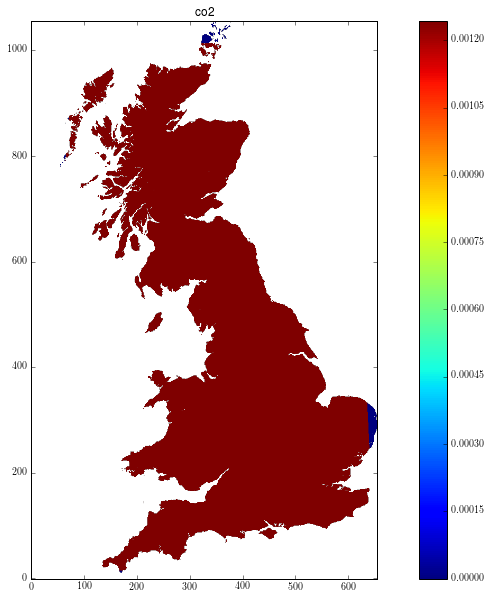

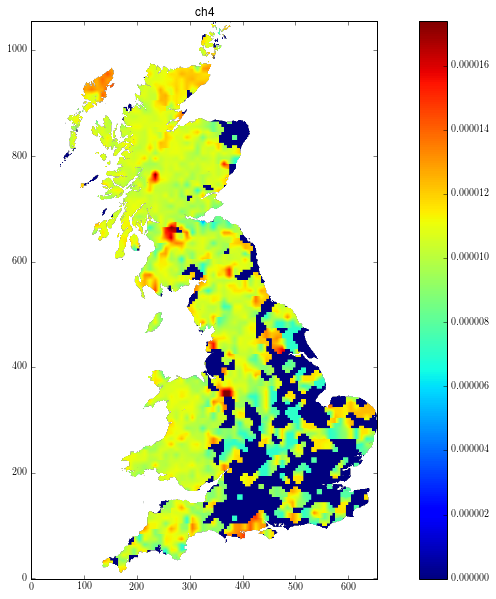

In [72]:


for var in PLEVY_DATA:
    plotdata=PLEVY_DATA[var]
    plt.imshow(plotdata,origin='bottom')
    plt.title(var)
    plt.colorbar()
    plt.show()




In [32]:
#print(np.min(PLEVY_DATA['co2'][PLEVY_DATA['co2']>0.01]))
#print(np.max(PLEVY_DATA['co2']))

In [36]:
print(JULES_DATA['npp_gb']['data'].mean(axis=0).shape)
print(JULES_DATA['resp_s_gb']['data'].shape)

(1057, 656)
(12, 1057, 656)


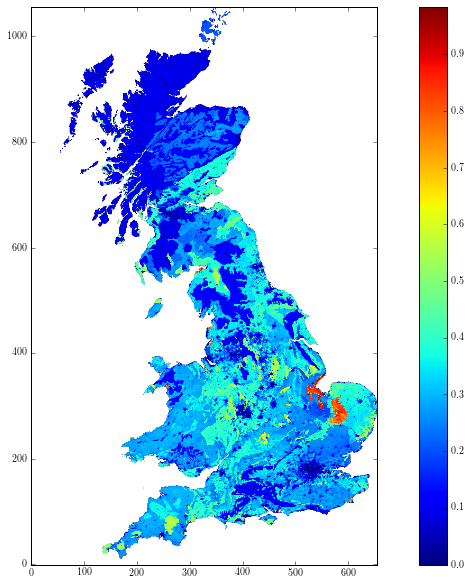

2.49775680774e-09
21757.2136814


In [59]:
kaps_factor = JULES_DATA['npp_gb']['data'].mean(axis=0) * 0.5e-8  \
             /  JULES_DATA['resp_s_gb']['data'].mean(axis=0)
plt.imshow(kaps_factor*1e8,origin='bottom')
plt.colorbar()
plt.show()
print(np.mean(kaps_factor))

print( (JULES_DATA['npp_gb']['data'].mean()*365.-0.45)/JULES_DATA['resp_s_gb']['data'].mean()*365. )

In [15]:

help(PTs.plot_map)

Help on function plot_map in module PlotTools.plot_tools:

plot_map(DATA, LONS, LATS, DATA2=None, LONS2=None, LATS2=None, GREYMASK=None, MASKCOLOR='grey', DATA_RANGE=None, LON_RANGE=None, LAT_RANGE=None, MAP_TYPE='Mesh', COLOURS=None, MPL_CBAR=None, CMAP=None, NLEVELS=None, CLEVELS=None, TickLEVELS=None, NTICKS=None, TickLABELS=None, CBAR_ORIENTATION='horizontal', CBAR_SIZE='6%', CBAR_PAD=0.3, INTERPOLATE_COLOURS=False, TICK_FORMAT='%.3f', CBAR_TICK_LENGTH=10, WIDTH=12, HEIGHT=8, CBAR_LABEL=None, PLOT_TITLE=None, FONTSIZES=[10, 10, 12, 12], iDISPLAY='N', iCLOSE='N', FILE_PLOT=None, iORIENTATION='landscape', FIGURE=None, AXIS=None, SET_OVER=None, SET_UNDER=None, LATDEL=None, LONDEL=None, RIVERS=False, RESOLUTION='i', PROJECTION='cyl', LEFT_FRAC=0.0, RIGHT_FRAC=0.0, BOTTOM_FRAC=0.0, TOP_FRAC=0.0, BOUNDINGLAT=35, LON_0=-32, LAT_0=90.0, RSPHERE=[6378137.0, 6356752.3142])
    ###############################################################################
    # Function: plot_map
    # Autho

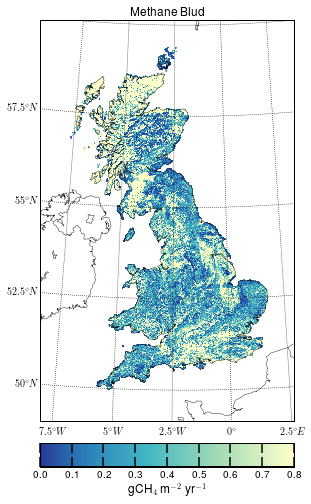

In [71]:
#fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(20,10))
CMAP=brewer2mpl.get_map('YlGnBu','Sequential','5',reverse=True).get_mpl_colormap(N=100,gamma=0.8)

JULES_Ann_ch4_emis=np.mean(JULES_DATA['fch4_wetl']['data'],axis=0)*365.*1e3*16./12.
PTs.plot_map(JULES_Ann_ch4_emis,lons_2D,lats_2D,CMAP=CMAP,\
             DATA_RANGE=[0,0.8],
             LATDEL=2.5,LONDEL=2.5,LON_RANGE=[-8,4],
             NLEVELS=100,NTICKS=9,CBAR_LABEL='gCH$_4$ m$^{-2}$ yr$^{-1}$',
             TICK_FORMAT='%0.1f',PLOT_TITLE='Methane Blud',
             PROJECTION='chess')

#PLevy_Ann_ch4_emis=PLEVY_DATA['ch4']*365*1e3*16./12.
#PTs.plot_map(PLevy_Ann_ch4_emis,lons_2D,lats_2D,CMAP=CMAP,\
#             #DATA_RANGE=[0,0.8],
#             LATDEL=2,LONDEL=2,
#             NLEVELS=100,NTICKS=9,CBAR_LABEL='gCH$_4$ m$^{-2}$ yr$^{-1}$',
#             AXIS=axes[1],PROJECTION='chess')

In [17]:
lons_2D.shape,lats_2D.shape,JULES_Ann_ch4_emis.shape

((1057, 656), (1057, 656), (1057, 656))

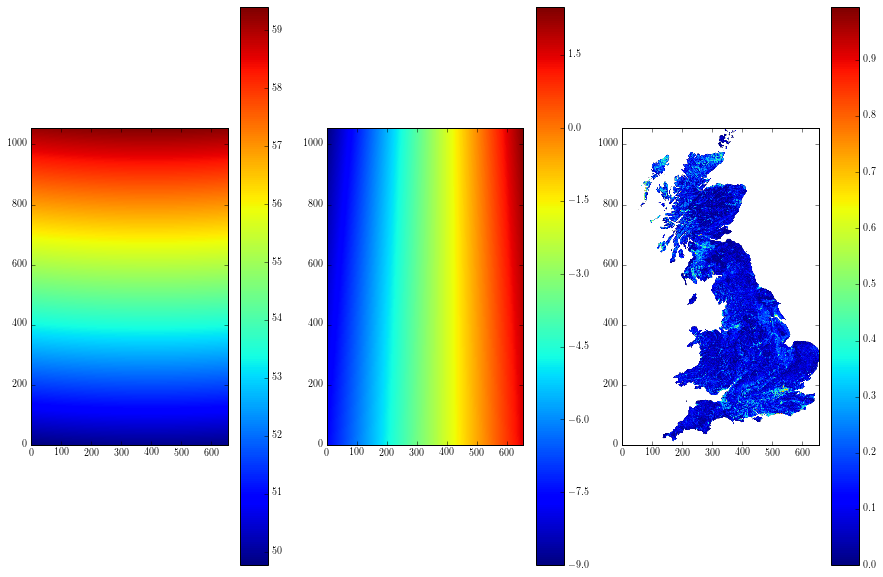

In [18]:
plt.subplot(1,3,1)
plt.imshow(lats_2D,origin='bottom')
plt.colorbar()

plt.subplot(132)
plt.imshow(lons_2D,origin='bottom')
plt.colorbar()

plt.subplot(133)
plt.imshow(JULES_Ann_ch4_emis,origin='bottom')
plt.colorbar()